This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [5]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K


batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "datasets/mnist_cluttered_60x60_6distortions.npz"

In [6]:
from spatial_transformer import SpatialTransformer

In [7]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
print("X_train sample:", X_train[0])
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))
#one hot
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))
print("sample output:",y_train)
print("output shape:", y_train.shape)
input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

('X_train sample:', array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32))
Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
('sample output:', array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]]))
('output shape:', (50000, 10))
('Input shape:', (60, 60, 1))


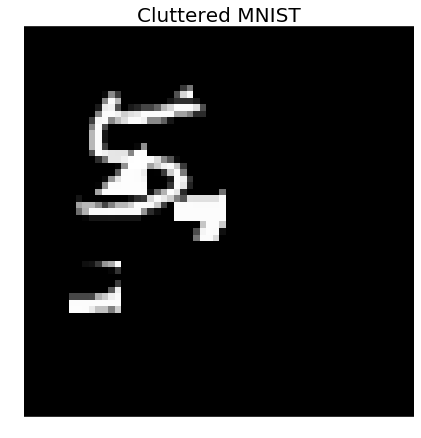

In [8]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [30]:
model = Sequential()

# model.add(SpatialTransformer(localization_net=locnet,
#                              output_size=(30,30), input_shape=input_shape))
model.add(Convolution2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 60, 60, 32)        320       
_________________________________________________________________
activation_24 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_25 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 32)        9248      
__________

In [33]:
nb_epochs = 50 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
#         print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            #print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev, accv = model.evaluate(X_valid, y_valid, verbose=1)
        scoret, acct = model.evaluate(X_test, y_test, verbose=1)
        if(e%1==0):
            print('Epoch: {0} | Valid Score: {1}| Test Score: {2}| Valid Acc: {3} | Test Acc: {4}'.format(e, scorev, scoret, accv, acct))
        
except KeyboardInterrupt:
    pass

10000/10000 [==============================] - 4s 362us/step
Epoch: 0 | Valid Score: 0.286230843526| Test Score: 0.276550117421| Valid Acc: 0.9092 | Test Acc: 0.9099
10000/10000 [==============================] - 3s 292us/step
Epoch: 1 | Valid Score: 0.257212904239| Test Score: 0.249329260373| Valid Acc: 0.9192 | Test Acc: 0.9193
10000/10000 [==============================] - 2s 156us/step
Epoch: 2 | Valid Score: 0.2397247015| Test Score: 0.234394685733| Valid Acc: 0.9276 | Test Acc: 0.9254
10000/10000 [==============================] - 2s 238us/step
Epoch: 3 | Valid Score: 0.244692544448| Test Score: 0.242233290547| Valid Acc: 0.9246 | Test Acc: 0.9239
10000/10000 [==============================] - 2s 238us/step
Epoch: 4 | Valid Score: 0.247610939517| Test Score: 0.247166746289| Valid Acc: 0.9258 | Test Acc: 0.9247
10000/10000 [==============================] - 2s 237us/step
Epoch: 5 | Valid Score: 0.249072590823| Test Score: 0.249876299232| Valid Acc: 0.9273 | Test Acc: 0.9259
10000/

### Visualizing what the Spatial Transformer learned

In [14]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

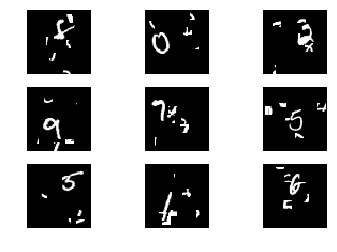

In [15]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

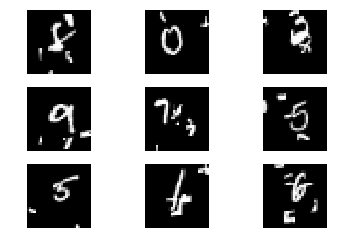

In [16]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

In [21]:
w = 3
h = 2
import numpy as np

In [22]:
x = np.linspace(0,1,w)
y = np.linspace(-3,-2,h)

In [23]:
x_t, y_t = np.meshgrid(x, y)

In [24]:
x

array([0. , 0.5, 1. ])

In [25]:
y

array([-3., -2.])

In [26]:
x_t

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [27]:
y_t

array([[-3., -3., -3.],
       [-2., -2., -2.]])

In [28]:
ones = np.ones(np.prod(x_t.shape))


In [29]:
sampling_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
sampling_grid

array([[ 0. ,  0.5,  1. ,  0. ,  0.5,  1. ],
       [-3. , -3. , -3. , -2. , -2. , -2. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ]])